In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
from scipy.spatial.distance import pdist, squareform

import warnings
import os
import pickle

from loader import load, get_formatted_data, get_raw_feature, DATA_DIR
from free_recall import create_fr_plots, split_by_feature, get_bounds
from fitness import format_text

In [2]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
data = get_formatted_data()
_, fitbit, _ = load(recent=7, baseline=30)

# do some cleaning up to make parsing easier in this notebook
columns = [': '.join(c) if len(c[0]) > 0 else c[1] for c in fitbit.columns]
columns = [c.replace(' / ', '/') for c in columns]
fitbit = pd.DataFrame(index=fitbit.index, columns=columns, data=fitbit.values).drop(columns=[c for c in columns if 'efficiency' in c])
fitbit['sleep duration: recent'] /= (60 * 60 * 1000) # convert ms to hours

In [4]:
with open(os.path.join(DATA_DIR, 'behavioral_summary.pkl'), 'rb') as f:
    behavioral = pickle.load(f)
bounds = [0, 25, 50, 75, 100]

In [5]:
tasks = ['Free recall', 'Naturalistic recall', 'Foreign language flashcards', 'Spatial learning']
conditions = ['Immediate', 'Delayed']

bounds = [0, 25, 50, 75, 100]
task_colors = {t: c for t, c in zip(tasks, ['#3FA9F5', '#7AC943', '#FF931E', '#FF1D25'])}
condition_colors = ['#CCCCCC', '#1A1A1A']

task_cmaps = {t: sns.color_palette(f'light:{c}', n_colors=len(bounds)) for t, c in task_colors.items()}
task_cmaps_extended = {t: sns.color_palette(f'light:{c}', as_cmap=True) for t, c in task_colors.items()}

# Load in fitness data

Get summaries of recent measurements and recent vs. baseline measurements:
  - Activity (steps, zone minutes, floors/elevation)
  - Resting heart rate
  - Sleep

In [6]:
fitness_tags = ['baseline' if 'baseline' in c else 'recent' if 'recent' in c else 'static' for c in fitbit.columns]
fitbit

,BMI,body fat,weight,resting heart rate: recent,resting heart rate: recent/baseline,sleep duration: recent,sleep duration: recent/baseline,steps: recent,steps: recent/baseline,distance: recent,...,excess calories: recent,out-of-range HR: recent,out-of-range HR: recent/baseline,fat burn HR: recent,fat burn HR: recent/baseline,cardio HR: recent,cardio HR: recent/baseline,peak HR: recent,peak HR: recent/baseline,HR variability
P0,27.770063,30.000,89.975,NaN,NaN,NaN,NaN,3470.875,0.915239,2.592866,...,446.750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
P1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,0.000000,...,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
P2,32.510139,25.000,99.790,77.625,0.985550,NaN,NaN,11147.375,1.267702,7.428272,...,1487.875,688.375,0.88621,643.500,1.122985,7.250,0.858255,0.25,1.187500,11.663580
P3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
P4,22.257710,NaN,62.596,NaN,NaN,NaN,NaN,0.000,NaN,0.000000,...,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P108,29.725172,29.868,86.108,NaN,NaN,NaN,NaN,0.000,0.000000,0.000000,...,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
P109,40.642212,NaN,117.456,55.875,0.990399,NaN,NaN,3571.375,2.819350,2.507102,...,940.000,1246.750,1.07393,66.875,0.869375,2.375,0.428819,0.25,0.180556,16.942527
P110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
P111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
behavioral_tags = ['delayed' if 'delayed' in c else 'immediate' for c in behavioral.columns]
behavioral

,Free recall (immediate),Free recall (delayed),Naturalistic recall (immediate),Naturalistic recall (delayed),Foreign language flashcards (immediate),Foreign language flashcards (delayed),Spatial learning (intercept),Spatial learning (slope)
P0,0.515625,0.187500,0.901203,0.917849,NaN,NaN,0.740677,0.620953
P1,0.984375,0.906250,0.850649,0.563574,0.8,NaN,0.830731,0.496952
P2,0.671875,0.265625,0.910146,0.831101,0.7,0.7,0.962055,0.080893
P3,0.468750,0.312500,0.851312,0.885206,NaN,NaN,0.801884,0.500854
P4,0.640625,0.328125,0.746228,0.773765,0.8,0.8,0.629321,0.80549
...,...,...,...,...,...,...,...,...
P108,0.281250,0.140625,0.728443,0.715547,0.3,0.5,0.254845,0.761135
P109,0.640625,0.375000,0.649809,0.780077,0.8,0.7,0.576616,0.617924
P110,0.453125,0.015625,0.874351,0.768864,0.9,0.7,0.784739,0.468243
P111,0.328125,0.062500,NaN,0.998227,0.6,0.5,0.612979,0.81629


# Plot distributions of fitness stats

For each column of the behavioral dataframe, divide participants based on behavioral performance (using `bounds`).  Then plot the distribution of each fitness variable.  Create one panel for each fitness variable, where each column has one distribution per group of particiapants (divided by behavior for that task).

Full figure:
  - Rows: behavioral columns
  - Columns: fitness vars
  - Each panel: distributions of fitness var-- one for each group (as defined by bounds applied to behavioral var)
  
Create 6 figures-- each combination of:
  - Immediate vs. delayed (behavioral)
  - Static vs. recent vs. baseline (fitness)

In [8]:
def split_distplots(vals, group_vals, bounds, cmap, bins=10, xlabel='Value', ylabel='Number of participants', fontsize=14, **kwargs):
    x = pd.DataFrame(vals)            
    x['group'] = np.digitize(group_vals, get_bounds(group_vals, bounds=bounds))
    x = x.query(f'group < {len(bounds)}').dropna(axis=0, how='any')        
    
    sns.histplot(x, x=x.columns[0], hue='group', palette=cmap[:len(np.unique(x['group']))],
                 fill=True, legend=False, bins=bins, **kwargs)
    
    ax = kwargs.pop('ax', plt.gca())
    if len(xlabel) > 0:
        ax.set_xlabel(xlabel, fontsize=fontsize)
    if len(ylabel) > 0:
        ax.set_ylabel(ylabel, fontsize=fontsize)

In [9]:
def split_scatterplots(vals, group_vals, bounds, cmap, xlabel='', ylabel='', fontsize=14, **kwargs):    
    sns.scatterplot(x=vals.values.ravel(), y=group_vals.values.ravel(), hue=group_vals.values.ravel(), palette=cmap,
                    legend=False, **kwargs)
    
    ax = kwargs.pop('ax', plt.gca())
    if len(xlabel) > 0:
        ax.set_xlabel(xlabel, fontsize=fontsize)
    if len(ylabel) > 0:
        ax.set_ylabel(ylabel, fontsize=fontsize)

In [10]:
def grid_helper(behavioral, fitbit, bounds, task_cmaps, plotfun, **kwargs):
    fig, axes = plt.subplots(nrows=len(behavioral.columns), ncols=len(fitbit.columns),
                             sharex='col', sharey='row', figsize=(2*len(fitbit.columns), 2*len(behavioral.columns)))

    for i, b in enumerate(behavioral.columns):                    
        cmap = [v for k, v in task_cmaps.items() if k in b][0]  # get this task's colormap        
        for j, f in enumerate(fitbit.columns):
            if i == len(behavioral.columns) - 1:
                xlabel = format_text(f)
            else:
                xlabel = ''    
            
            if j == 0:
                ylabel = format_text(b)
            else:
                ylabel = ''
                        
            plotfun(pd.DataFrame(index=fitbit.index, columns=[format_text(f)], data=fitbit[f].values),
                    behavioral[b], bounds, cmap=cmap, ax=axes[i, j], 
                    xlabel=xlabel, ylabel=ylabel, fontsize=8,
                    **kwargs)

    return fig

In [11]:
def distplot_grid(behavioral, fitbit, bounds, task_cmaps, bins=10, **kwargs):
    return grid_helper(behavioral, fitbit, bounds, task_cmaps, split_distplots, bins=bins, **kwargs)

In [12]:
def scatterplot_grid(behavioral, fitbit, bounds, task_cmaps, **kwargs):
    return grid_helper(behavioral, fitbit, bounds, task_cmaps, split_scatterplots, **kwargs)

In [13]:
def grid_plotter(behavioral, fitbit, behavioral_tags, fitness_tags, gridplotter, task_cmaps, **kwargs):
    for task_cond in np.unique(behavioral_tags):
        b = behavioral.loc[:, np.array(behavioral_tags) == task_cond]
        for fit_cond in np.unique(fitness_tags):
            f = fitbit.loc[:, np.array(fitness_tags) == fit_cond]

            plt.clf()
            fig = gridplotter(b, f, bounds, task_cmaps, **kwargs)

            fname = f'{task_cond}_{fit_cond}_{gridplotter.__name__}.pdf'
            fig.savefig(fname)

<Figure size 432x288 with 0 Axes>

<Figure size 2016x432 with 0 Axes>

<Figure size 2016x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

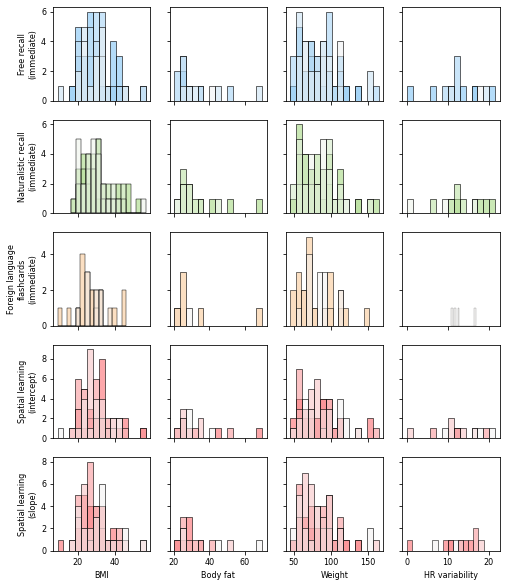

In [14]:
grid_plotter(behavioral, fitbit, behavioral_tags, fitness_tags, distplot_grid, task_cmaps, bins=15)

<Figure size 432x288 with 0 Axes>

<Figure size 2016x432 with 0 Axes>

<Figure size 2016x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

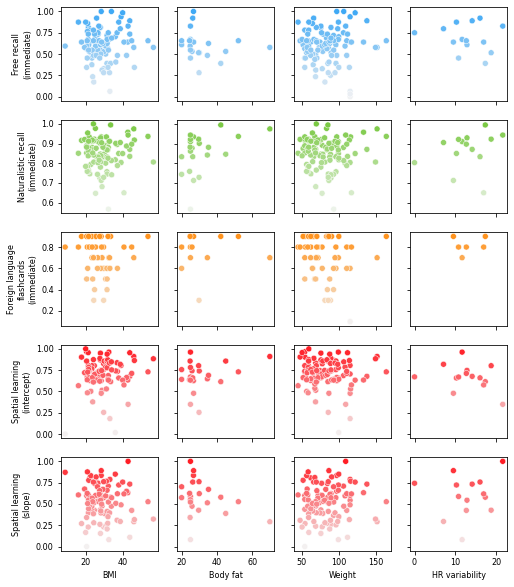

In [15]:
grid_plotter(behavioral, fitbit, behavioral_tags, fitness_tags, scatterplot_grid, task_cmaps_extended)

# Plot distributions of fitness variables

In [16]:
color_dict = {f: c for f, c in zip(np.unique(fitness_tags), ['#A81A8A', '#1D2A7C', '#B29802'])}


for i, c in enumerate(fitbit.columns):
    plt.clf()
    fig = plt.figure(figsize=(3, 3))
    
    sns.displot(fitbit[c], kde=True, color=color_dict[fitness_tags[i]])
    plt.ylabel('Number of participants', fontsize=14)
    plt.xlabel(format_text(c, width=50), fontsize=14)
    
    plt.savefig(f"{c.replace(':', '-').replace('/', '-').replace(' ', '')}_dist.pdf")
    plt.close()

/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)
/tmp/ipykernel_799/4110361643.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(3, 3))


<Figure size 432x288 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

In [18]:
fitbit

,BMI,body fat,weight,resting heart rate: recent,resting heart rate: recent/baseline,sleep duration: recent,sleep duration: recent/baseline,steps: recent,steps: recent/baseline,distance: recent,...,excess calories: recent,out-of-range HR: recent,out-of-range HR: recent/baseline,fat burn HR: recent,fat burn HR: recent/baseline,cardio HR: recent,cardio HR: recent/baseline,peak HR: recent,peak HR: recent/baseline,HR variability
P0,27.770063,30.000,89.975,NaN,NaN,NaN,NaN,3470.875,0.915239,2.592866,...,446.750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
P1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,0.000000,...,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
P2,32.510139,25.000,99.790,77.625,0.985550,NaN,NaN,11147.375,1.267702,7.428272,...,1487.875,688.375,0.88621,643.500,1.122985,7.250,0.858255,0.25,1.187500,11.663580
P3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
P4,22.257710,NaN,62.596,NaN,NaN,NaN,NaN,0.000,NaN,0.000000,...,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P108,29.725172,29.868,86.108,NaN,NaN,NaN,NaN,0.000,0.000000,0.000000,...,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
P109,40.642212,NaN,117.456,55.875,0.990399,NaN,NaN,3571.375,2.819350,2.507102,...,940.000,1246.750,1.07393,66.875,0.869375,2.375,0.428819,0.25,0.180556,16.942527
P110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
P111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
with open(os.path.join(DATA_DIR, 'fitness_summary.pkl'), 'wb') as f:
    pickle.dump(fitbit, f)